In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [2]:
mean_gray = 0.1307
stddev_gray = 0.3081

# input[channel] = (input[channel] - mean[channel]) / std[channel]
# Normalize the image with mean and standard deviation of the dataset.
# The first parameter is the mean of the dataset, and the second parameter is the standard deviation of the dataset.

transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((mean_gray,), (stddev_gray,))])

# Load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms)


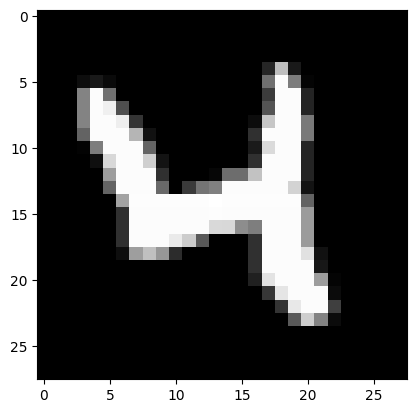

In [3]:
# Visualize the dataset
# Denormalize the image
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28, 28), cmap='gray')

In [4]:
# Label of the above image
train_dataset[20][1]

4

In [5]:
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_load = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
len(train_load)

600

![cnn mnist](https://user-images.githubusercontent.com/30661597/61713471-3c957d00-ad8b-11e9-9a38-e3f4d1e72565.png)

In [7]:
# Create the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 1st convolutional layer
        # Same padding: (kernel_size - 1) / 2; same padding means the output size is the same as the input size.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        # The output size of each of the 8 feature maps:
        # [(input_size - filter_size + 2 * padding) / stride] + 1 = [(28 - 3 + 2 * 1) / 1] + 1 = [27 / 1] + 1 = 28
        # Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        # Apply ReLU activation function
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # The output size of each of the 8 feature maps:
        # [(input_size - filter_size + 2 * padding) / stride] + 1 = [(28 - 2 + 2 * 0) / 2] + 1 = [26 / 2] + 1 = 14

        # 2nd convolutional layer
        # Choose the output channels to be 32
        # Choose the kernel size to be 5
        
        
        # Same padding = (5 - 1) / 2 = 2
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        # The output size of each of the 32 feature maps:# [(input_size - filter_size + 2 * padding) / stride] + 1 = [(14 - 5 + 2 * 2) / 1] + 1 = [13 / 1] + 1 = 14
        # Batch normalization
        self.batchnorm2 = nn.BatchNorm2d(32)
        # We don't need to specify the activation function here, because we are using the same kernel size max pooling specified earlier.
        # Output size of each of the 32 feature maps: [(14 - 2 + 2 * 0) / 2] + 1 = [12 / 2] + 1 = 7

        # Flatten the 32 feature maps: 32 * 7 * 7 = 1568
        self.fc1 = nn.Linear(in_features=32*7*7, out_features=600)
        # Dropout layer is used to prevent overfitting and is only used during training.
        self.dropout = nn.Dropout(p=0.5)
        # Second fully connected layer
        self.fc2 = nn.Linear(in_features=600, out_features=10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        # Flatten the output of the second convolutional layer
        out = out.view(-1, 32*7*7)

        # First fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [9]:
# Create the model
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
